# ML - Kaggle Animal Shelter Outcome / Random Forest Classifier

## Python loading

In [137]:
import sys

import pandas as pd
from pandas import DataFrame, Series

import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 

%matplotlib inline

## Read train and test data

In [138]:
train = pd.read_csv("../../data/train.csv", index_col=0)
test = pd.read_csv("../../data/test.csv", index_col=0)

train.head(2)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby


## Data fitting

### Sex
The gender can be described as Male and Female. Nevertheless the data also includes information whether the animal is sterilized or not. For the fitting the information is split into two columns: Gender type (Male/Female) and Intact (Y/N).

In [139]:
train.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [140]:
train = pd.read_csv("../../data/train.csv", index_col=0)
test = pd.read_csv("../../data/test.csv", index_col=0)

def replaceing(dataset):
    opt = dataset.copy()

    opt["Intact"] = opt.SexuponOutcome.replace("Intact Male", "Yes")
    opt.Intact = opt.Intact.replace("Neutered Male", "No")
    opt.Intact = opt.Intact.replace("Spayed Female", "No")
    opt.Intact = opt.Intact.replace("Intact Female", "Yes")
    opt.Intact = opt.Intact.replace("Unknown", np.nan)

    opt.SexuponOutcome = opt.SexuponOutcome.replace("Neutered Male", "Male")
    opt.SexuponOutcome = opt.SexuponOutcome.replace("Intact Male", "Male")
    opt.SexuponOutcome = opt.SexuponOutcome.replace("Spayed Female", "Female")
    opt.SexuponOutcome = opt.SexuponOutcome.replace("Intact Female", "Female")
    opt.SexuponOutcome = opt.SexuponOutcome.replace("Unknown", np.nan)

    return opt

train = replaceing(train)
test = replaceing(test)

### Color

In [141]:
train.Color = train.Color.apply(lambda x: x.split("/")[0])
test.Color = test.Color.apply(lambda x: x.split("/")[0])

### Breed

In [142]:
train.Breed = train.Breed.apply(lambda x: x.split("/")[0])
test.Breed = test.Breed.apply(lambda x: x.split("/")[0])

### Data categorising
The columns are still containing data as String. We're using Pandas categories type for handling these values as integers.

In [143]:
train.Intact = train.Intact.astype("category")
train["IntactValue"] = train.Intact.cat.codes
test.Intact = test.Intact.astype("category", train.Intact.cat.categories.values.tolist())
test["IntactValue"] = test.Intact.cat.codes

train.SexuponOutcome = train.SexuponOutcome.astype("category")
train["SexuponOutcomeValue"] = train.SexuponOutcome.cat.codes
test.SexuponOutcome = test.SexuponOutcome.astype("category", train.SexuponOutcome.cat.categories.values.tolist())
test["SexuponOutcomeValue"] = test.SexuponOutcome.cat.codes

train.OutcomeType = train.OutcomeType.astype("category")

In [144]:
train.Color = train.Color.astype("category")
train["ColorValue"] = train.Color.cat.codes

test.Color = test.Color.astype("category", categories=train.Color.cat.categories.values.tolist())
test["ColorValue"] = test.Color.cat.codes

In [145]:
train.Breed = train.Breed.astype("category")
test.Breed = test.Breed.astype("category", categories=train.Breed.cat.categories.values.tolist())

train["BreedValue"] = train.Breed.cat.codes
test["BreedValue"] = test.Breed.cat.codes

train["Breed"].value_counts().head(5)

Domestic Shorthair Mix      8810
Pit Bull Mix                1906
Chihuahua Shorthair Mix     1766
Labrador Retriever Mix      1363
Domestic Medium Hair Mix     839
dtype: int64

#### Test for training with names

In [146]:
train["FirstLetter"] = train.Name.str[0]
test["FirstLetter"] = test.Name.str[0]

train["FirstLetter"] = train["FirstLetter"].astype("category")
test["FirstLetter"] = test["FirstLetter"].astype("category", categories=train.FirstLetter.cat.categories.values.tolist())

train["FirstLetterValue"] = train["FirstLetter"].cat.codes
test["FirstLetterValue"] = test["FirstLetter"].cat.codes

### Test the categorising

In [147]:
test[test.Color == "Red"].head(1)

,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,IntactValue,SexuponOutcomeValue,ColorValue,BreedValue,FirstLetter,FirstLetterValue
ID,,,,,,,,,,,,,,
1,Summer,2015-10-12 12:15:00,Dog,Female,10 months,Labrador Retriever Mix,Red,Yes,1,0,40,221,S,22


In [148]:
train[train.Color=="Red"].head(1)

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,IntactValue,SexuponOutcomeValue,ColorValue,BreedValue,FirstLetter,FirstLetterValue
AnimalID,,,,,,,,,,,,,,,,
A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Female,5 months,American Pit Bull Terrier Mix,Red,No,0,0,40,18,L,15


In [149]:
# Codes are representing the strings as a integer value
train.head(5).SexuponOutcome.cat.codes

AnimalID
A671945    1
A656520    0
A686464    1
A683430    1
A667013    1
dtype: int8

## More advanced data fitting
### Put AgeuponOutcome to (not Pandas) categories like Young/Old/Adult

In [150]:
train.AgeuponOutcome = train.AgeuponOutcome.fillna("-1 days")
test.AgeuponOutcome = test.AgeuponOutcome.fillna("-1 days")

def calcYearValue(x):
    factor = 1
    if str(x).split(" ")[1].startswith("day"):
        return 1#factor = 0
    #elif str(x).split(" ")[1].startswith("month"):
    #    factor = 12
    elif str(x).split(" ")[1].startswith("month"):
        factor = 30
    elif str(x).split(" ")[1].startswith("year"):
        factor = 356
        
    if str(x).split(" ")[0] == "-1":
        return -1
    else:
        return int(int(str(x).split(" ")[0]) * factor)
    
def calcAgeCategory(x):
    factor = 1
    if str(x).split(" ")[1].startswith("day"):
        return "very young"
    elif str(x).split(" ")[1].startswith("month") or str(x).split(" ")[1].startswith("week"):
        return "young"
    elif str(x).split(" ")[1].startswith("year") and int(str(x).split(" ")[0]) < 5:
        return "young adult"
    elif str(x).split(" ")[1].startswith("year") and int(str(x).split(" ")[0]) < 10:
        return "adult"
    return "old"


train["AgeuponOutcomeYears"] = train.AgeuponOutcome.apply(lambda x: calcYearValue(x))

train["AgeCategory"] = train.AgeuponOutcome.apply(lambda x: calcAgeCategory(x))
test["AgeCategory"] = test.AgeuponOutcome.apply(lambda x: calcAgeCategory(x))

train["AgeCategory"] = train["AgeCategory"].astype("category")
test["AgeCategory"] = test["AgeCategory"].astype("category", categories=train["AgeCategory"].cat.categories.values.tolist())

train["AgeCategoryValue"] = train["AgeCategory"].cat.codes
test["AgeCategoryValue"] = test["AgeCategory"].cat.codes

In [151]:
train[train.AgeuponOutcome.str.startswith("1") & train.AgeuponOutcome.str.contains("years")].AgeuponOutcome.value_counts()

10 years    446
12 years    234
13 years    143
11 years    126
14 years     97
15 years     85
16 years     36
17 years     17
18 years     10
19 years      3
Name: AgeuponOutcome, dtype: int64

Let's see the distributon of the years. The peaks are a result of the multiplication of "high units" like day->week->month->year

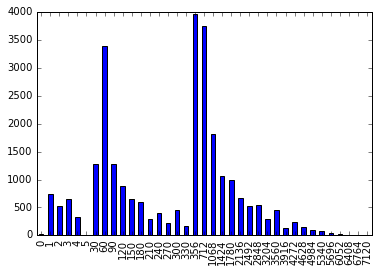

In [152]:
mean = int(train[train.AgeuponOutcomeYears != -1].AgeuponOutcomeYears.mean())
train.AgeuponOutcomeYears = train.AgeuponOutcomeYears.apply(lambda x: mean if x == -1 else x)

#train.AgeuponOutcomeYears = train.AgeuponOutcomeYears.apply(lambda x: 4 if x > 4 else x)

train.AgeuponOutcomeYears.value_counts().sort_index().plot(kind="bar")

In [153]:
len(train[~train.AgeuponOutcome.str.contains("year")])

11886

The distribution of the categories looks pretty good :-)

In [154]:
train.AgeCategory.value_counts()

young          11470
young adult    10627
adult           3017
old             1199
very young       416
dtype: int64

## Prediction

In [155]:
# Let's predict with a Random Forest Classifier!
rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1)

predict_cols = ["SexuponOutcomeValue", "IntactValue", "ColorValue", 'BreedValue', 'AgeCategoryValue']

d_train = train[predict_cols].values
d_target = train.OutcomeType.cat.codes.values

## Fit

In [156]:
rf.fit(d_train, d_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Predict

In [157]:
myTest = test.copy()

result = None 

#predictOn = myTest[['SexuponOutcomeValue', 'IntactValue', 'ColorValue', 'BreedValue', 'AgeCategoryValue']]
predictOn = myTest[predict_cols]

calcPredictProbas = rf.predict_proba(predictOn.values) # withs probalilities

In [158]:
ii = 0
for index, row in myTest.iterrows():
    probas = calcPredictProbas[ii]
    
    #for i in probas:
    if result is None:
        result = DataFrame(columns=["ID"])
        result.set_index("ID")

        for j in range(0, len(probas)):
            result[train.OutcomeType.cat.categories[j]] = None
            print(train.OutcomeType.cat.categories[j])

    newLine = [index]
    newLine.extend(probas)
    #print(newLine)
    result.loc[len(result)] = newLine
            
result.head()


Adoption
Died
Euthanasia
Return_to_owner
Transfer


,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1.0,0.055338,0.018539,0.108457,0.18227,0.635397
1,2.0,0.055338,0.018539,0.108457,0.18227,0.635397
2,3.0,0.055338,0.018539,0.108457,0.18227,0.635397
3,4.0,0.055338,0.018539,0.108457,0.18227,0.635397
4,5.0,0.055338,0.018539,0.108457,0.18227,0.635397


In [159]:
result["ID"] = result["ID"].astype(int)
result.set_index("ID", inplace=True)
result.to_csv("result.csv")

result.head(15)

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
ID,,,,,
1,0.055338,0.018539,0.108457,0.18227,0.635397
2,0.055338,0.018539,0.108457,0.18227,0.635397
3,0.055338,0.018539,0.108457,0.18227,0.635397
4,0.055338,0.018539,0.108457,0.18227,0.635397
5,0.055338,0.018539,0.108457,0.18227,0.635397
6,0.055338,0.018539,0.108457,0.18227,0.635397
7,0.055338,0.018539,0.108457,0.18227,0.635397
8,0.055338,0.018539,0.108457,0.18227,0.635397
9,0.055338,0.018539,0.108457,0.18227,0.635397
